# KPI : Feux de forêt - Gestion des risques 

## 1. Création de la base de données

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.ticker as ticker

In [7]:
#Open Initial database
filepath1 = "data/Incendies/Incendies_2006_2016.csv"
filepath2 = "data/Incendies/Incendies_2016_2023.csv"
dataframe1 = pd.read_csv(filepath1, sep=";", skiprows=6)
dataframe2 = pd.read_csv(filepath2, sep=";", skiprows=3)
df = pd.concat([dataframe1, dataframe2])

#Open Current INSEE Codes
filepath3 = "data/Incendies/Correspondance Communes - EPCI.csv"
cp = pd.read_csv(filepath3, sep=";")

#Open Old INSEE Codes
filepath4 = "data/Incendies/table_passage_geo2003_geo2024.xlsx"
convert = pd.read_excel(filepath4 , skiprows=5)

# To check that size of Code INSEE's values are always equal to 5
longueursCodeInsee = df['Code INSEE'].astype(str).str.len()
valeurs_uniques = longueursCodeInsee.unique()
print(valeurs_uniques)

# Check for null values in all columns
df.info(show_counts=True)

# To convert m2 to km2
df['Surface parcourue (km2)'] = df['Surface parcourue (m2)'] * 1e-6
df['Surface forêt (km2)']=df['Surface forêt (m2)'] * 1e-6
df['Surface maquis garrigues (km2)'] = df['Surface maquis garrigues (m2)']  * 1e-6
df['Autres surfaces naturelles hors forêt (km2)'] = df['Autres surfaces naturelles hors forêt (m2)']  * 1e-6
df['Surfaces agricoles (km2)'] = df['Surfaces agricoles (m2)'] * 1e-6
df['Surfaces non boisées (km2)'] = df['Surfaces non boisées (m2)'] * 1e-6
df['Surfaces non boisées artificialisées (km2)'] = df['Surfaces non boisées artificialisées (m2)'] * 1e-6
df['Surfaces non boisées naturelles (km2)'] = df['Surfaces non boisées naturelles (m2)'] * 1e-6
df['Surface autres terres boisées (km2)'] = df['Surface autres terres boisées (m2)'] * 1e-6
df['Autres surfaces (km2)'] = df['Autres surfaces (m2)'] * 1e-6

# To drop unused columns
df = df.drop(columns=['Département','Numéro','Nom de la commune','Date de première alerte','Précision des surfaces','Type de peuplement','Nature','Décès ou bâtiments touchés','Nombre de décès','Nombre de bâtiments totalement détruits','Nombre de bâtiments partiellement détruits','Précision de la donnée','Surface parcourue (m2)','Surface forêt (m2)','Surface maquis garrigues (m2)','Autres surfaces naturelles hors forêt (m2)','Surfaces agricoles (m2)','Surfaces non boisées (m2)','Surfaces non boisées artificialisées (m2)','Surfaces non boisées naturelles (m2)','Surface autres terres boisées (m2)','Autres surfaces (m2)'])

[5]
<class 'pandas.core.frame.DataFrame'>
Index: 51705 entries, 0 to 23453
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Année                                       51705 non-null  int64  
 1   Numéro                                      51705 non-null  int64  
 2   Département                                 51705 non-null  object 
 3   Code INSEE                                  51705 non-null  object 
 4   Nom de la commune                           51678 non-null  object 
 5   Date de première alerte                     51705 non-null  object 
 6   Surface parcourue (m2)                      51705 non-null  int64  
 7   Surface forêt (m2)                          38964 non-null  float64
 8   Surface maquis garrigues (m2)               19443 non-null  float64
 9   Autres surfaces naturelles hors forêt (m2)  20615 non-null  float64
 10  Surfaces ag

In [8]:
# Merging with Antoine's file to have CODGEO
df_final = df.merge(cp[["CODGEO", "LIBGEO", "EPCI","LIBEPCI","DEP","REG"]], 
              left_on="Code INSEE", 
              right_on="CODGEO", 
              how="left")
df_final = df_final.sort_values(by='CODGEO')
df_final = df_final.reset_index(drop=True)

In [10]:
# Preparing dataframe for final export
df_export = df_final.dropna(subset=['CODGEO'])
df_export = df_export.drop(columns=["Code INSEE"])

In [11]:
# Exporting dataframes
df_export.to_csv('data/output/Incendies.csv', index=False)

## 2. Quelques indicateurs / visualisations

In [17]:
# Number of fires not matched (obsolete INSEE codes)
df_final['CODGEO'].isnull().sum()

np.int64(480)

In [16]:
# Number of communities not matched (obsolete INSEE codes)
df_final.groupby('Code INSEE')['CODGEO'].apply(lambda x: x.isnull().all()).sum()

np.int64(187)

In [18]:
df_export['CODGEO'].isnull().sum()

np.int64(0)

In [19]:
# Area covered by fire, by year and by community
df_surfaces_incendiées_par_collectivite_et_annee = df_export.groupby(['CODGEO','Année'])['Surface parcourue (km2)'].sum().reset_index()

# Number of fires per community
df_nombre_incendies_par_collectivite = df_export.groupby(['CODGEO']).size().reset_index(name='fire_count')

# Number of fires per community, including communities with 0 fires
merged_df = cp.merge(cp, on='CODGEO', how='left') \
               .merge(df_nombre_incendies_par_collectivite, on='CODGEO', how='left')

merged_df['fire_count'] = merged_df['fire_count'].fillna(0).astype(int)
merged_df['Surface parcourue (km2)'] = merged_df['Surface parcourue (km2)'].fillna(0).astype(float)
merged_df = merged_df.drop(columns=['LIBGEO','EPCI','LIBEPCI','DEP','REG'])
merged_df

KeyError: 'Surface parcourue (km2)'

### Nombre d'incendies au total

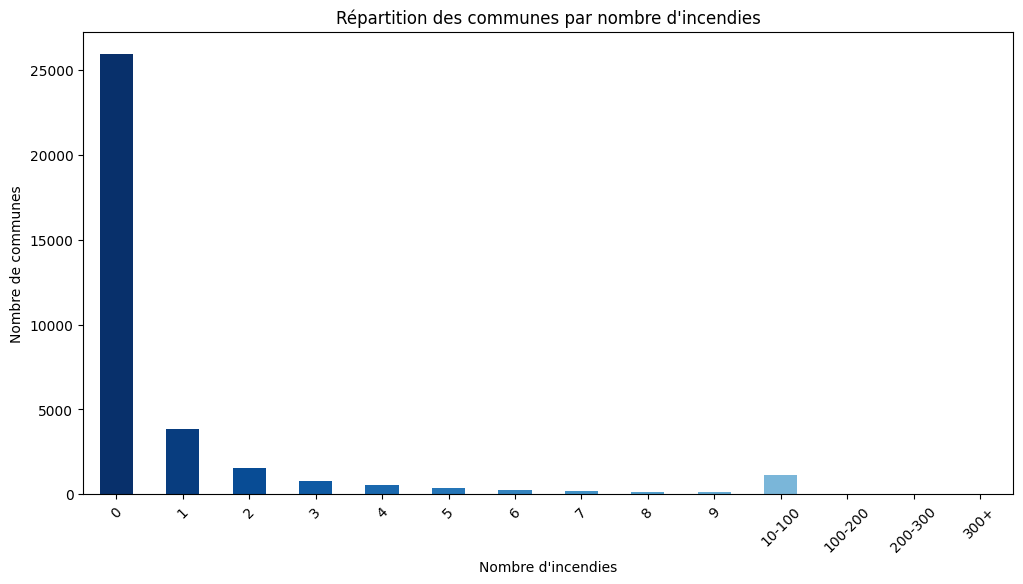

In [20]:
# Define bins for grouping fire counts
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 200, 300, float('inf')]
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10-100', '100-200', '200-300', '300+']

# Create a new column with grouped categories
merged_df['fire_count_group'] = pd.cut(merged_df['fire_count'], bins=bins, labels=labels, right=False)

# Count the number of cities per fire count group
fire_count_distribution = merged_df['fire_count_group'].value_counts().sort_index()

# Generate colors from light to dark (by reversing the colormap gradient)
colors = cm.Blues(np.linspace(1, 0.3, len(fire_count_distribution)))  # Reversed

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
fire_count_distribution.plot(kind='bar', color=colors, ax=ax)

# Labels and Title
plt.xlabel("Nombre d'incendies")
plt.ylabel("Nombre de communes")
plt.title("Répartition des communes par nombre d'incendies")
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [26]:
# Step 1: Count the number of cities for each fire_count value
fire_count_distribution = merged_df['fire_count'].value_counts().sort_index()

# Step 2: Get the total number of cities (constant value)
total_cities_count = len(merged_df)

# Step 3: Create a new DataFrame
fire_count_summary_df = pd.DataFrame({
    'fire_count': fire_count_distribution.index,  # Unique fire counts
    'num_cities': fire_count_distribution.values,  # Number of cities with that fire count
})

# Step 4: Add a column for the total number of cities (same for all rows)
fire_count_summary_df['total_cities'] = total_cities_count

# Display the final DataFrame
fire_count_summary_df

,fire_count,num_cities,total_cities
0,0,25947,34936
1,1,3867,34936
2,2,1560,34936
3,3,800,34936
4,4,530,34936
...,...,...,...
114,261,1,34936
115,301,1,34936
116,323,1,34936
117,326,1,34936


### Evolution du nombre d'incendie par années

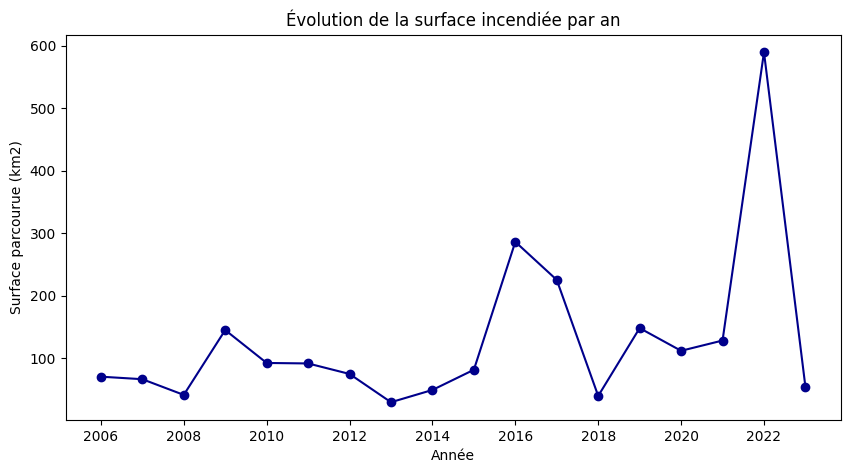

In [23]:
# Summary table
df_yearly_sum = df_surfaces_incendiées_par_collectivite_et_annee.groupby('Année', as_index=False)['Surface parcourue (km2)'].sum()
df_yearly_sum = df_yearly_sum.sort_values(by='Année', ascending=True)

# Line plot
plt.figure(figsize=(10, 5))
plt.plot(df_yearly_sum['Année'], df_yearly_sum['Surface parcourue (km2)'], marker='o', linestyle='-', color='#00008B')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Labels and title
plt.xlabel('Année')
plt.ylabel('Surface parcourue (km2)')
plt.title('Évolution de la surface incendiée par an')
plt.grid(False)

plt.show()

### Top 10 communes avec le plus de surfaces incendiées

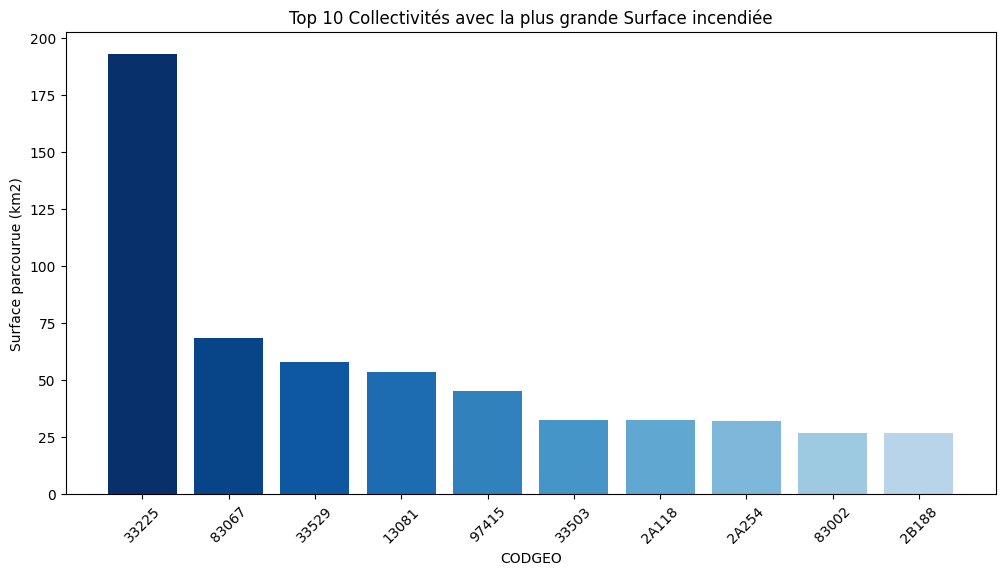

In [24]:
# Group by 'CODGEO' and sum the 'Surface parcourue (km2)'
df_top_codgeo = df_surfaces_incendiées_par_collectivite_et_annee.groupby('CODGEO', as_index=False)['Surface parcourue (km2)'].sum()
df_top_codgeo = df_top_codgeo.nlargest(10, 'Surface parcourue (km2)')
df_top_codgeo['CODGEO'] = df_top_codgeo['CODGEO'].astype(str)

# Generate colors from light to dark (by reversing the colormap gradient)
colors = cm.Blues(np.linspace(1, 0.3, len(df_top_codgeo)))  # Reversed

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(df_top_codgeo['CODGEO'], df_top_codgeo['Surface parcourue (km2)'], color=colors)

# Labels and title
plt.xlabel('CODGEO')
plt.ylabel('Surface parcourue (km2)')
plt.title('Top 10 Collectivités avec la plus grande Surface incendiée')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()
